![](https://i.imgur.com/qkg2E2D.png)

# UnSupervised Learning Methods

## Exercise 004 - Part II

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 0.1.000 | 16/06/2023 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/UnSupervisedLearningMethods/2023_03/Exercise0004Part002.ipynb)

In [ ]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import make_s_curve, make_swiss_roll

# Computer Vision

# Miscellaneous
import os
import math
from platform import python_version
import random
import time
import urllib.request

# Typing
from typing import Callable, List, Tuple, Union

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image, display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout

from scipy.spatial.distance import cdist


## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

In [ ]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [ ]:
# Constants

DATA_FILE_URL   = r'None'
DATA_FILE_NAME  = r'None'


In [ ]:
# Auxiliary Functions

def GetData(MakeData: Callable, Nx: int, Ny: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    mX, vCx = MakeData(Nx)
    mY, vCy = MakeData(Ny)

    return mX, mY, vCx, vCy

def PlotTrainTestData(mX: np.ndarray, mY: np.ndarray, vCx: np.ndarray, vCy: np.ndarray, hA: plt.Axes, Is3DData: bool = False) -> None:
    m = mX.min()
    M = mX.max()

    hA.scatter(*mX.T, s = 25, c = vCx, edgecolor = 'k', alpha = 1, label = 'Train', vmin = vCx.min(), vmax = vCx.max())
    hA.scatter(*mY.T, s = 100, c = 'r', marker = '*', alpha = 1, label = 'Test')
    hA.set_xlim([m, M])
    hA.set_ylim([m, M])
    if Is3DData:
        hA.set_zlim([m, M])
    hA.set_xlabel('$x_1$')
    hA.set_ylabel('$x_2$')
    if Is3DData:
        hA.set_zlabel('$x_3$')
    hA.legend()

## Guidelines

 - Fill the full names and ID's of the team members in the `Team Members` section.
 - Answer all questions / tasks within the Jupyter Notebook.
 - Use MarkDown + MathJaX + Code to answer.
 - Verify the rendering on VS Code.
 - Submission in groups (Single submission per group).
 - You may and _should_ use the forums for questions.
 - Good Luck!

* <font color='brown'>(**#**)</font> The `Import Packages` section above imports most needed tools to apply the work. Please use it.
* <font color='brown'>(**#**)</font> You may replace the suggested functions to use with functions from other packages.
* <font color='brown'>(**#**)</font> Whatever not said explicitly to implement maybe used by a 3rd party packages.
* <font color='brown'>(**#**)</font> The total run time of this notebook must be **lower than 30 [Sec]**.

## Generate / Load Data

In [ ]:
# Download Data
# This section downloads data from the given URL if needed.

if (DATA_FILE_NAME != 'None') and (not os.path.exists(DATA_FILE_NAME)):
    urllib.request.urlretrieve(DATA_FILE_URL, DATA_FILE_NAME)

## 7. MDS

### 7.1. Classic MDS Algorithm

In this section we'll implement a SciKit Learn API compatible class for the Classic MDS.  

The class should implement the following methods:

1. `__init____()` - The object constructor by the encoder dimension.  
2. `fit()` - Given a data set ($\boldsymbol{D}_{xx}$) builds the encoder.  
3. `transform()` - Applies the encoding on the input data ($\boldsymbol{D}_{xy}$) in out of sample manner.  
4. `fix_transform()` - Given a data set ($\boldsymbol{D}_{xx}$) builds the encoder and applies the encoding.  

* <font color='brown'>(**#**)</font> Pay attention to data structure (`Nx x Nx` / `Nx x Ny`).
* <font color='brown'>(**#**)</font> Do not use any loops in you implementation.

In [ ]:
class CMDS():
    def __init__(self, d: int = 2):
        '''
        Constructing the object.
        Args:
            d - Number of dimensions of the encoder output.
        '''
        #===========================Fill This===========================#
        # 1. Keep the model parameters.

        self.d = d
        #===============================================================#

    def fit(self, mDxx: np.ndarray):
        '''
        Fitting model parameters to the input.
        Args:
            mDxx - Input data (Distance matrix) with shape Nx x Nx.
        Output:
            self
        '''
        #===========================Fill This===========================#
        # 1. Build the model encoder.

        mDxx_square        = mDxx    # **2  # Assume given distacne matrix is distance square  and not distance
        mDxx_square_col    = mDxx_square - mDxx_square.mean(axis = 1).reshape(-1,1)
        mDxx_square_center_row_and_col = mDxx_square_col - mDxx_square_col.mean(axis = 0).reshape(1,-1)

        kernel_mat         = -0.5*mDxx_square_center_row_and_col

        s2, v       = sp.sparse.linalg.eigsh(kernel_mat , k=self.d , which='LM' , return_eigenvectors=True)
        s2          = s2[::-1]
        v           = v[:,::-1]

        s_inv             =  1/np.sqrt(s2)
        s_inv_matrix = np.eye(self.d)*s_inv.reshape(-1,1)

        self.term1 = np.matmul(s_inv_matrix , v.T ) # Store for later OOS

        self.mDxx    = mDxx  # Store for later OOS


        #===============================================================#
        return self

    def transform(self, mDxy: np.ndarray) -> np.ndarray:
        '''
        Applies (Out of sample) encoding.
        Args:
            mDxy - Input data (Distance matrix) with shape Nx x Ny.
        Output:
            mZ - Low dimensional representation (embeddings) with shape Ny x d.
        '''
        #===========================Fill This===========================#
        # 1. Encode data using the model encoder.

        # Assume mDxy is already **2. Anyway control on square is outside of the class
        tmp1       = (mDxy -  self.mDxx.mean(axis = 1).reshape(-1,1)  )

        Kyx_gal    = -0.5* (tmp1 - tmp1.mean(axis = 0).reshape(1,-1) )


        mZ         = np.matmul(self.term1 , Kyx_gal)

        mZ     = mZ.T   # Return to shape of samples * dimension
        #===============================================================#

        return mZ

    def fit_transform(self, mDxx: np.ndarray) -> np.ndarray:
        '''
        Applies encoding on the input.
        Args:
            mDxx - Input data (Distance matrix) with shape Nx x Nx.
        Output:
            mZ - Low dimensional representation (embeddings) with shape Nx x d.
        '''
        #===========================Fill This===========================#
        # 1. Encode data using the model encoder.

        self.fit(mDxx)
        mZ  = self.transform(mDxx)
        #===============================================================#

        return mZ


* <font color='red'>(**?**)</font> Will `fit()` and then `transform()` will match the result of `fit_transform()`?  
  Make sure you understand this before proceeding.

For training data doing OOS will match the same as doing fit_transform. Therefore in the above implementation the fit_tranform is done by calling the two functions and not using the shorter formula for transforming the training data

### 7.2. Metric MDS Algorithm

In this section we'll implement a SciKit Learn API compatible class for the Metric MDS.  
The implementation will assume the distance matrix is generated using the _Eculidean_ distance (**Not _Squared Euclidean_**).  
The solver will use the Majorization Minimization algorithm.

The class should implement the following methods:

1. `__init____()` - The object constructor by the encoder dimension.  
2. `fit()` - Given a data set ($\boldsymbol{D}_{xx}$) initializes the data structures.  
3. `fit_transform()` - Given a data set ($\boldsymbol{D}_{xx}$) builds the encoder and applies the encoding.  

* <font color='brown'>(**#**)</font> Pay attention to data structure (`Nx x Nx` / `Nx x Ny`).
* <font color='brown'>(**#**)</font> Do not use any loops in you implementation beside the main MM loop.
* <font color='brown'>(**#**)</font> Think about the difference in `transform()` and `fit_transform()` compared to `CMDS()` above.

In [ ]:
class MMDS():
    def __init__(self, d: int = 2, maxIter = 500, ε = 1e-6 ):
        '''
        Constructing the object.
        Args:
            d       - Number of dimensions of the encoder output.
            maxIter - Maximum number of iterations for the Majorization Minimization.
            ε       - Convergence threshold.
            n       - Number of times algotrithm runs to take the best run
        '''
        #===========================Fill This===========================#
        # 1. Keep the model parameters.

        self.d       = d
        self.maxIter = maxIter
        self.ε       = ε
        #===============================================================#

    def fit(self, mDxx: np.ndarray):
        '''
        Fitting model parameters to the input.
        Args:
            mDxx - Input data (Distance matrix) with shape Nx x Nx.
        Output:
            self
        '''
        #===========================Fill This===========================#
        # 1. Build the model encoder.

        one_zero_diag_mat = np.ones((mDxx.shape[0],mDxx.shape[0])) - np.eye(mDxx.shape[0])
        self.C =  -mDxx * one_zero_diag_mat

        #===============================================================#
        return self

    def fit_transform(self, mDxx: np.ndarray) -> np.ndarray:
        '''
        Applies encoding on input data.
        Args:
            mDxx - Input data (Distance matrix) with shape Nx x Nx.
        Output:
            mZ - Low dimensional representation (embeddings) with shape Nx x d.
        '''
        #===========================Fill This===========================#
        # 1. Apply the `fit()` method.
        # 2. Applies the Majorization Minimization.
        # 3. Encode data using the model encoder.
        # !! Use no loops beside the main loop (`maxIter`).
        epsilon = 1e-20

        N = mDxx.shape[0]

        self.fit(mDxx)

        last_loss = np.inf

        mZ =  np.random.uniform(low = 0 , high = 10 , size = (self.d,N))  # work with dimensions according to  to math

        for iter_num in range(self.maxIter):

            Dz = cdist(mZ.T , mZ.T, metric='euclidean') # Note:  cdist works on rows

            C  = self.C / (Dz+epsilon)  # (add epsilon to avoid 0/0 on the diagonal)

            C1_diag = np.eye(N) * (C.sum(axis = 1).reshape(-1,1))

            B  = C - C1_diag

            mZ = 1/N * mZ@B

            # Stop condition based on delta of obective function
            mZ_dist = cdist(mZ.T , mZ.T, metric='euclidean') # Note:  cdist works on rows
            loss    = np.linalg.norm(mDxx - mZ_dist)
            if abs(loss - last_loss) < self.ε:
                break
            else:
                last_loss = loss

        #===============================================================#
        return mZ.T  # back to N*d


<b>Note:   
in real implementation need to run the function multiple times (from different starting points)  and select the lowest value.
We implemented only single run as understood this is the requirement (single maxiter loop only !)

* <font color='red'>(**?**)</font> Why is the `transform()` method not asked to be implemented?  
  Make sure you understand this before proceeding.

<b>
Transformed method is not implemented as metric MDS does not support OOS

### 7.3. Apply MDS on Data

In this section the MDS (Using the above classes) will be applied on several data sets:

 * Swiss Roll - Generated using `make_swiss_roll()`.
 * S Curve - Generated using `make_s_curve()`.

For each data set:

1. Plot the Data Set  
   Plot the Data set in 3D.  
   **This is implemented**.
2. Calculate the Distance Matrix  
   Calculate the distance matrix of the training data (`mX1`, `mX2`).  
   For _Classic MDS_ use the _Squared Euclidean_ distance.  
   For _Metric MDS_ use the _Euclidean_ distance.
3. Apply the MDS  
   On each data set, apply both the _Metric MDS_ and _Classic MDS_.  
4. Plot Low Dimensional Data  
   Make a scatter plot of $\boldsymbol{Z} \in \mathbb{R}^{d \times N}$ and color the data points according to `vCx1` and `vCx2`.  
   Use `d = 2`.

* <font color='brown'>(**#**)</font> Pay attention to the difference in dimensions of the data to the derived Math formulations.
* <font color='brown'>(**#**)</font> The output should be 2 figures for each data set. You may show them in a single plot using sub plots.

In [ ]:
# Generate Data

Nx = 1000 #<! Train Data
Ny = 10 #<! Test Data (Out of Sample)

mX1, mY1, vCx1, vCy1 = GetData(make_s_curve, Nx, Ny)
mX2, mY2, vCx2, vCy2 = GetData(make_swiss_roll, Nx, Ny)

# Centering Data
vμX1 = np.mean(mX1, axis = 0)
vμX2 = np.mean(mX2, axis = 0)

mX1 -= np.reshape(vμX1, (1, -1))
mY1 -= np.reshape(vμX1, (1, -1))
mX2 -= np.reshape(vμX2, (1, -1))
mY2 -= np.reshape(vμX2, (1, -1))

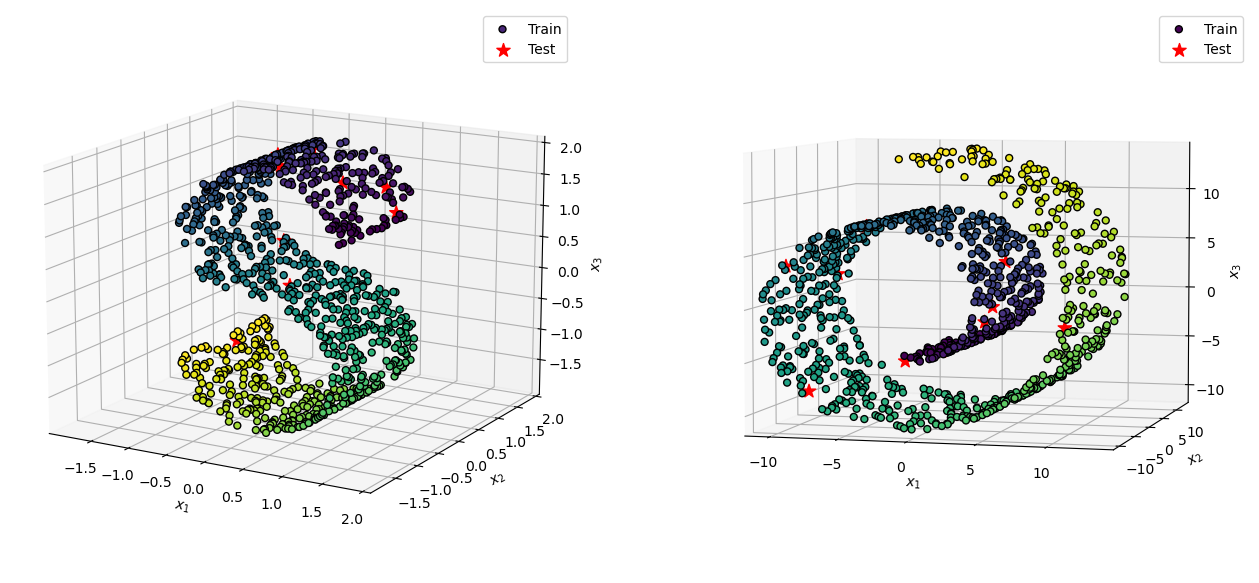

In [ ]:
# Plot Data
# Pay attention how to display the train (Out of Sample) data

hF = plt.figure(figsize = (16, 8))
hA1 = hF.add_subplot(1, 2, 1, projection = '3d')
hA2 = hF.add_subplot(1, 2, 2, projection = '3d')
hA1.view_init(elev = 15, azim = 300)
hA2.view_init(elev = 5, azim = 285)

PlotTrainTestData(mX1, mY1, vCx1, vCy1, hA1, Is3DData = True)
PlotTrainTestData(mX2, mY2, vCx2, vCy2, hA2, Is3DData = True)

Wall time: 1min 8s


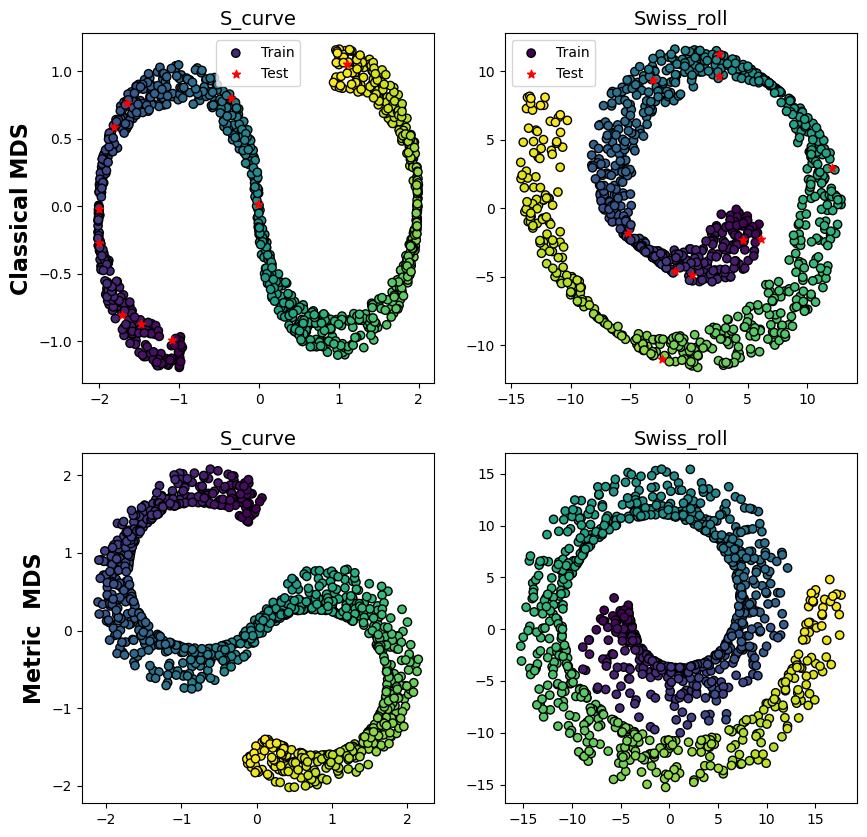

In [ ]:
%%time
#===========================Fill This===========================#
# 1. Set parameter `d`.
# 2. Calculate the distance matrices of the training data per data set.
# 3. Apply Classic MDS and Metric MDS to each data set.
# 4. Display results as scattered data.
# !! The output should be a figure of 2 x 2 (Row: Method, Column: Data Set).

d = 2

Dx_s_curve_train    = cdist(mX1 , mX1, metric='euclidean') # Note:  cdist works on rows
Dx_s_curve_test     = cdist(mX1 , mY1, metric='euclidean') # Note:  cdist works on rows

Dx_swiss_roll_train = cdist(mX2 , mX2, metric='euclidean') # Note:  cdist works on rows
Dx_swiss_roll_test  = cdist(mX2 , mY2, metric='euclidean') # Note:  cdist works on rows


# classial MDS
CMDS_s_curve          = CMDS(d = d)
mZ_cmds_s_curve_train = CMDS_s_curve.fit_transform(Dx_s_curve_train**2)
mZ_cmds_s_curve_test  = CMDS_s_curve.transform(Dx_s_curve_test**2)

CMDS_swiss_roll = CMDS(d = d)
mZ_cmds_swiss_roll_train  = CMDS_swiss_roll.fit_transform(Dx_swiss_roll_train**2)
mZ_cmds_swiss_roll_test   = CMDS_swiss_roll.transform(Dx_swiss_roll_test**2)

# Metric MDS
maxIter    = 500
MMDS_s_curve          = MMDS (d = d , maxIter = maxIter)
mZ_mmds_s_curve_train = MMDS_s_curve.fit_transform(Dx_s_curve_train)

MMDS_swiss_roll           = MMDS (d = d , maxIter = maxIter)
mZ_mmds_swiss_roll_train  = MMDS_swiss_roll.fit_transform(Dx_swiss_roll_train)


fig, axes = plt.subplots( 2, 2, figsize=(10, 10))


# CLassical MDS
axes[0,0].set_ylabel(f'Classical MDS', fontsize=16,fontweight="bold")
axes[0,0].set_title(f'S_curve', fontsize=14, ha="center" )
axes[0,0].scatter(mZ_cmds_s_curve_train[:,0], mZ_cmds_s_curve_train[:,1] , c = vCx1 , edgecolor = 'k' , label = 'Train' )
axes[0,0].scatter(mZ_cmds_s_curve_test[:,0], mZ_cmds_s_curve_test[:,1] , c = 'r' , marker = '*' , label = 'Test' )
axes[0,0].legend()


axes[0,1].set_title(f'Swiss_roll', fontsize=14, ha="center" )
axes[0,1].scatter(mZ_cmds_swiss_roll_train[:,0], mZ_cmds_swiss_roll_train[:,1] , c = vCx2 , edgecolor = 'k' , label = 'Train' )
axes[0,1].scatter(mZ_cmds_swiss_roll_test[:,0], mZ_cmds_swiss_roll_test[:,1] , c = 'r' , marker = '*' , label = 'Test' )
axes[0,1].legend()


# Metric MDS
axes[1,0].set_ylabel(f'Metric  MDS', fontsize=16,fontweight="bold")
axes[1,0].set_title(f'S_curve', fontsize=14, ha="center" )
axes[1,0].scatter(mZ_mmds_s_curve_train[:,0], mZ_mmds_s_curve_train[:,1] , c = vCx1 , edgecolor = 'k' , label = 'Train' )
#axes[0,1].legend()

axes[1,1].set_title(f'Swiss_roll', fontsize=14, ha="center" )
axes[1,1].scatter(mZ_mmds_swiss_roll_train[:,0], mZ_mmds_swiss_roll_train[:,1] , c = vCx2 , edgecolor = 'k' , label = 'Train' )
#axes[0,1].legend()




#===============================================================#

### 7.4. Question

1. Explain the differences / similarities between results.
2. Describe the distance function which should be used for such data.
3. What results would you expect if the distance for the Metric MDS was the _Squared Euclidean_?  
   Assume the optimal solder for this distance.

### 7.4. Solution

1. The difference between the results is due to different in the objective functions. Classical MDS aims to preserve the dot product between the instance while Metric MDS tries to preserve the distance (in our case it is L2). While the classical MDS preserves the order of the distance it does not aim to preserve the distance value itself.

2. We should use the geodesic distance for this data. As shown in HW3 this distance can be achieved by only 2 dimensions: The original X2 dimension and the location on the main axis of the figure


3. We would expect the original shape to be distorted as distance square does not properly represent the original image. The metric MDS will aims  to preserve the square distance. Points with bigger distances will be mapped to relatively  larger distance in the embedding space  

### 7.5. Out of Sample Extension

In this section the _out of sample extension_ of the _Classic MDS_ (Using the above class) will be applied.  
In this section the calculation of the out of sample extension will be done without using the test data samples (`mX1`, `mX2`)!

For `mY1` and `mY2`:

1. Calculate the Distance Matrix  
   Calculate `Dxy1` and `Dxy2` **without using `mX1` and `mX2`**.  
   You may use `Dxx1` and `Dxx2` in any way suitable.   
   For _Classic MDS_ use the _Squared Euclidean_ distance.  
   For _Metric MDS_ use the _Euclidean_ distance.
3. Apply the Out of Sample Extension for Classic MDS  
   On each data set, apply the Classic MDS in _out of sample extension_ mode on `mDxy1` and `mDxy2`.
4. Plot Low Dimensional Data  
   Make a scatter plot of $\boldsymbol{Z} \in \mathbb{R}^{d \times N}$ and color the data points according to `vCx1`, `vCx2`.   
   You should plot both the training data and the test data.
   Use `d = 2`.

* <font color='brown'>(**#**)</font> Pay attention to the difference in dimensions of the data to the derived Math formulations.
* <font color='brown'>(**#**)</font> You may use the knowledge about the dimensions of `mX1`, `mX2`.
* <font color='brown'>(**#**)</font> In case one fails on (1) one may calculate `mDxy` using `mX` (Points will be reduced).
* <font color='brown'>(**#**)</font> The output should be 2 figures for each data set. You may show them in a single plot using sub plots.

In [ ]:
#===========================Fill This===========================#
# 1. Set parameter `d`.
# 2. Calculate the distance matrices of the test data per data set from `mDxx1` and `mDxx2`.
# 3. Apply Classic MDS to each data set.
#    Apply `fit()` then `transform()` on `mDxx1` and `mDxx2`.
#    Apply `transform()` on `mDxy1` and `mDxy2`.
# 4. Display results as scattered data.
#    Display both the train and test data on the same axes (See above).
# !! The output should be a figure of 1 x 2 (Row: Method, Column: Data Set).
# !! Hint: You should recover the data from `mDxx`.

d = 2

def mDxy_reconstrct(Dxx , mY):
    CMDS_d3      = CMDS(d = 3)
    mX_hat       = CMDS_d3.fit_transform(Dxx**2)
    mDxy_hat     = cdist(mX_hat , mY1, metric='euclidean') # Note:  cdist works on rows
    return mDxy_hat , mX_hat

# CMDS_s_curve was already fitted with train distance in previous section
Dx_s_curve_test_hat , mX1_hat   = mDxy_reconstrct(Dx_s_curve_train , mY1)
mZ_cmds_s_curve_test_hat        = CMDS_s_curve.transform(Dx_s_curve_test_hat**2)

# CMDS_swiss_roll was already fitted with train distance in previous section
Dx_swiss_roll_test_hat , mX2_hat    = mDxy_reconstrct(Dx_swiss_roll_train , mY2)
mZ_cmds_swiss_roll_test_hat         = CMDS_swiss_roll.transform(Dx_swiss_roll_test_hat**2)


#===============================================================#

<b>
After we have reconstructed the data only from the distance matrix, we plot the data again in 3D.   
As expected the data is similar to the original data up to rotation and shift.  
However, this is not good for our task as rotation and shift do impact the distance to the test data.....

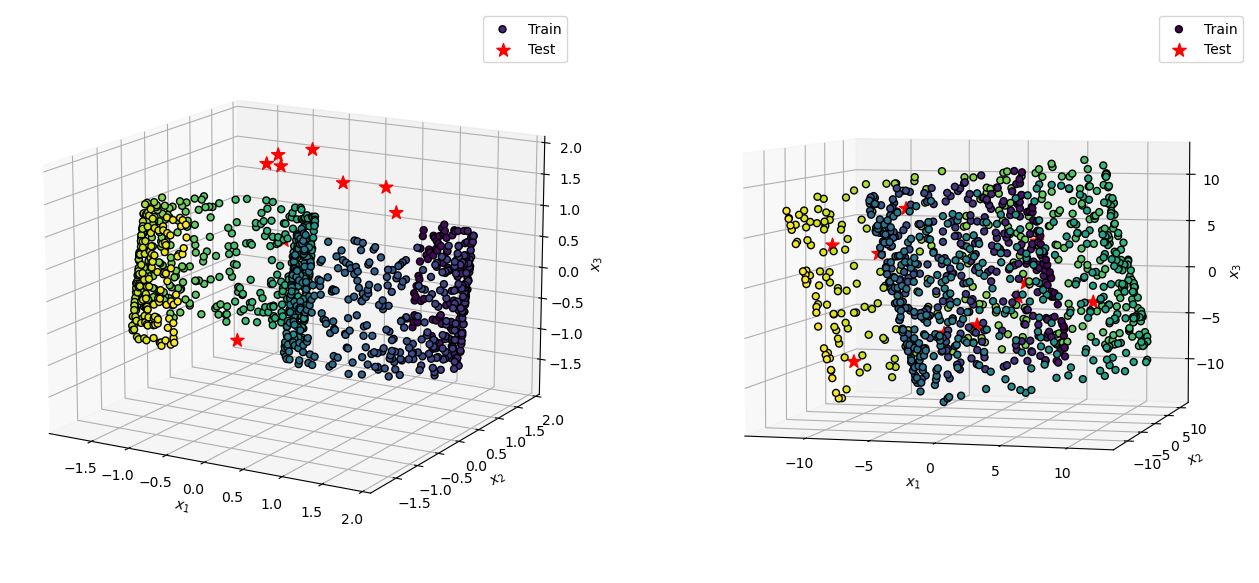

In [ ]:
hF = plt.figure(figsize = (16, 8))
hA1 = hF.add_subplot(1, 2, 1, projection = '3d')
hA2 = hF.add_subplot(1, 2, 2, projection = '3d')
hA1.view_init(elev = 15, azim = 300)
hA2.view_init(elev = 5, azim = 285)

PlotTrainTestData(mX1_hat, mY1, vCx1, vCy1, hA1, Is3DData = True)
PlotTrainTestData(mX2_hat, mY2, vCx2, vCy2, hA2, Is3DData = True)

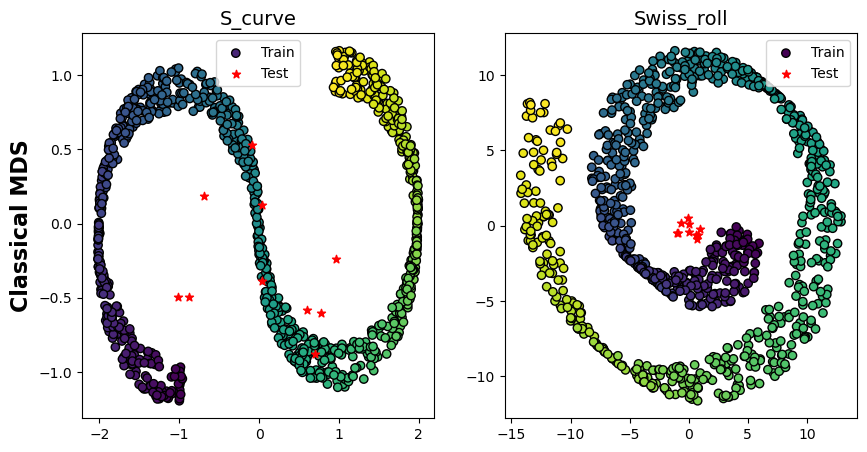

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(10, 5))


# CLassical MDS
axes[0].set_ylabel(f'Classical MDS', fontsize=16,fontweight="bold")
axes[0].set_title(f'S_curve', fontsize=14, ha="center" )
axes[0].scatter(mZ_cmds_s_curve_train[:,0], mZ_cmds_s_curve_train[:,1] , c = vCx1 , edgecolor = 'k' , label = 'Train' )
axes[0].scatter(mZ_cmds_s_curve_test_hat[:,0], mZ_cmds_s_curve_test_hat[:,1] , c = 'r' , marker = '*' , label = 'Test' )
axes[0].legend()


axes[1].set_title(f'Swiss_roll', fontsize=14, ha="center" )
axes[1].scatter(mZ_cmds_swiss_roll_train[:,0], mZ_cmds_swiss_roll_train[:,1] , c = vCx2 , edgecolor = 'k' , label = 'Train' )
axes[1].scatter(mZ_cmds_swiss_roll_test_hat[:,0], mZ_cmds_swiss_roll_test_hat[:,1] , c = 'r' , marker = '*' , label = 'Test' )
axes[1].legend()


### 7.6. Question

Are the results above good?  
Will they match the results if one would calculate `mDxy` from `mX` and `mY`?  

### 7.6. Solution

As expected, the results are not good at all !
Results are not good for the OOS since we have reconstructed the mX points from the Dxx however the mX now only reflects the original mX up to rotation and shift. Calculating distance between these reconstructed points and the test points is not valid.
In the previous plot we added the test points when calculated with the real distance of mDxy (from real mX) and  as can be seen the results are very good
